# 09. PyTorch Model Deployment

What is Model Deployment

Machine Learning model department is the act of making your machine learning or something else.

## Resources:

* Book version of notebook: (https://www.learnpytorch.io/09_pytorch_model_deployment/)
* Slides: (https://github.com/mrdbourke/pytorch-deep-learning/blob/main/slides/09_pytorch_model_deployment.pdf)

# 0. Get setup

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from torchinfo import summary
from helper_functions import download_data, set_seeds, plot_loss_curves

print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


In [2]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 1. Getting Data

The dataset we're going to use for deploying a FoodVision Mini model is..

Pizza, steak, sushi 20% dataset(pizza, steak and sushi calsses from Food101, random 20% of samples)

We can get data with code from: (https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data)

In [3]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi_20_percent')

In [4]:
# Setup training and test paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

# 2. FoodVision Mini model deployment experiment outline

### 3 Questions
1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

**FoodVision Mini ideal use case:** A model that performs well and fast.

1. Performs well: 95%+ accuracy
2. Fast: as close to real-time (or faster) as possible (30FPS+ or 30ms latency)
   * Latency = time for prediction to take place

To try to achieve these goals, we're going to build two model experiments:
1. EffNetB2 feature extractor (just like in 07. PyTorch Experiment Tracking)
2. ViT feature extractor (just like in 08. PyTorch Paper Replicating)

# 3. Creating an EffNetB2 feature extractor

Feature extractor = a term for a transfer learning model that has its base layers frozen and output layers (or head layers) customized to a certain problem.

EffNetB2 pretrained model in PyTorch: (https://docs.pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html#efficientnet-b2)

In [5]:
import torchvision

# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" is equivalent to "Best available weights"

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="default"

# 4. Freeze the base layers in the model (this will stop all layers from training)
for param in effnetb2.parameters():
    param.requires_grad = False

In [6]:
from torchinfo import summary

summary(model=effnetb2,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=["var_names"]) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [7]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
# Set seeds for reproducibilty
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
)

In [9]:
from torchinfo import summary

summary(model=effnetb2,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=["var_names"]) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### Difference between Feature Extractor Model v/s Fine Tuning model

#### Feature Extraction:
* You freeze ALL feature layers (e.g., all Conv2d layers in a CNN).

* You usually replace or modify the classifier head (the linear layers on top).

* You only train the new classifier head.

#### Fine-tuning:
* You unfreeze SOME or ALL feature layers (Conv2d layers).

* You usually still replace or modify the classifier head.

* You train everything (or part of the backbone) so it adapts to your new data.

#### In simpler words:

* **Feature extraction** = freeze all Conv layers. Train classifier only.

* **Fine-tuning** = unfreeze some Conv layers. Train them (and classifier).

## 3.1 Creating a function to make an EffNetB2 feature extractor

In [10]:
def create_effnetb2_model(num_classes:int=3, # default output classes = 3(pizza, steak, sushi)
                          seed:int=42):

    # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in the base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )

    return model, transforms

In [11]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [12]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [13]:
from torchinfo import summary

summary(model=effnetb2,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=["var_names"]) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 3.2 Creating DataLoaders for EffNetB2

In [49]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = 0

def create_dataloaders(
  train_dir: str,
  test_dir: str,
  transform: transforms.Compose,
  batch_size: int,
  num_workers: int=NUM_WORKERS  
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directroy path and turns them into 
  PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=path/to/train_dir,
        test_dir=path/to/test_dir,
        transform=some_transform,
        batch_size=32,
        num_workers=4)
  """
  # Use ImageFolder to create datasets(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into DataLoaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True # for more on pin memory, see the PyTorch docs: https://pytorch.org/docs/stable/data.html 
  )

  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True
  )

  return train_dataloader, test_dataloader, class_names


In [15]:
# Setup DataLoaders
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=effnetb2_transforms,
                                                                               batch_size=32)

In [16]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

## 3.3 Training EffNetB2 feature extractor

In [18]:
from going_modular import engine

# loss function
loss_fn = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(params = effnetb2.parameters(),
                             lr=1e-3)

# Training function (engine.py)
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

C:\Users\Deepam Shah\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 10%|█         | 1/10 [00:12<01:55, 12.79s/it]

Epoch: 1 | train_loss: 0.9832 | train_acc: 0.5750 | test_loss: 0.7411 | test_acc: 0.9409


 20%|██        | 2/10 [00:18<01:10,  8.81s/it]

Epoch: 2 | train_loss: 0.7182 | train_acc: 0.8479 | test_loss: 0.5867 | test_acc: 0.9347


 30%|███       | 3/10 [00:26<00:56,  8.12s/it]

Epoch: 3 | train_loss: 0.5841 | train_acc: 0.8958 | test_loss: 0.4877 | test_acc: 0.9625


 40%|████      | 4/10 [00:33<00:46,  7.76s/it]

Epoch: 4 | train_loss: 0.4470 | train_acc: 0.9125 | test_loss: 0.4332 | test_acc: 0.9409


 50%|█████     | 5/10 [00:40<00:37,  7.51s/it]

Epoch: 5 | train_loss: 0.4264 | train_acc: 0.9104 | test_loss: 0.3890 | test_acc: 0.9443


 60%|██████    | 6/10 [00:47<00:29,  7.25s/it]

Epoch: 6 | train_loss: 0.4468 | train_acc: 0.8812 | test_loss: 0.3500 | test_acc: 0.9688


 70%|███████   | 7/10 [00:54<00:21,  7.16s/it]

Epoch: 7 | train_loss: 0.4276 | train_acc: 0.8729 | test_loss: 0.3245 | test_acc: 0.9625


 80%|████████  | 8/10 [01:01<00:14,  7.12s/it]

Epoch: 8 | train_loss: 0.3817 | train_acc: 0.9042 | test_loss: 0.3441 | test_acc: 0.9352


 90%|█████████ | 9/10 [01:08<00:07,  7.09s/it]

Epoch: 9 | train_loss: 0.3740 | train_acc: 0.8833 | test_loss: 0.3111 | test_acc: 0.9256


100%|██████████| 10/10 [01:15<00:00,  7.55s/it]

Epoch: 10 | train_loss: 0.3710 | train_acc: 0.8625 | test_loss: 0.2805 | test_acc: 0.9625


## 3.4 Inspecting EffNetB2 loss curves

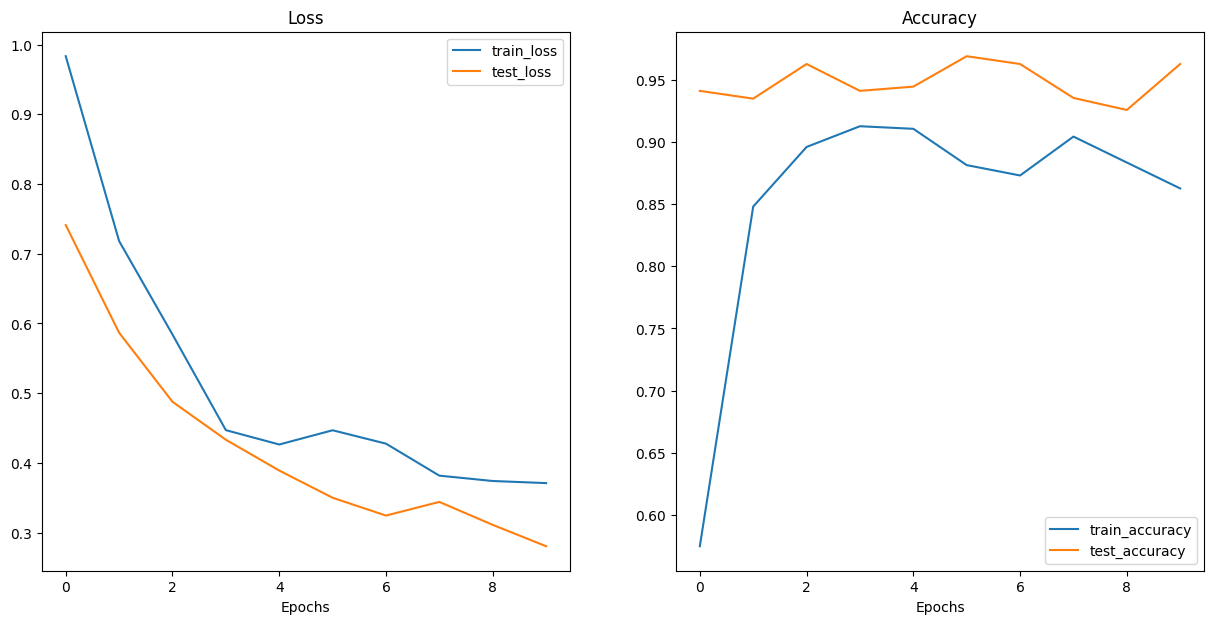

In [19]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

For accuracy improvements:- (https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/)

In [20]:
from going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_Pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\09_Pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


## 3.6 Inspecting the size of our EffNetB2 feature extractor

Why would it be important to consider the size of a saved model?

If we're deploying our model to be used on a mobile app/website, there may be limited compute resources

So if our model file is too large, we may not be able to store/run it on our target device.

In [24]:
from pathlib import Path

# get the model size in bytes and convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_Pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


## 3.7 Collecting EffNetB2 feature extractor stats

In [25]:
# Count number of parameters in EffnetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [26]:
list(effnetb2.parameters())

[Parameter containing:
 tensor([[[[ 4.5455e-02,  7.6288e-02,  3.0048e-02],
           [ 5.5432e-01,  2.9662e-01, -3.1593e-02],
           [ 7.8309e-01,  2.3778e-01, -7.0381e-02]],
 
          [[-2.9542e-01, -2.2617e-01,  4.4444e-02],
           [-1.1007e+00, -7.1409e-01, -5.0454e-02],
           [-1.4469e+00, -6.2652e-01, -6.3332e-03]],
 
          [[ 2.2284e-01,  1.2584e-01, -2.9721e-02],
           [ 6.2338e-01,  4.4390e-01,  4.5707e-02],
           [ 6.7145e-01,  4.5727e-01,  7.3647e-03]]],
 
 
         [[[-3.9284e-02, -2.5299e-02,  1.4641e-02],
           [ 5.2415e-02, -2.0318e-01,  1.3882e-01],
           [ 9.2027e-02, -9.3667e-01,  9.1768e-01]],
 
          [[-7.7375e-02, -2.6244e-02,  4.9299e-02],
           [ 2.1007e-01, -6.1103e-01,  4.3788e-01],
           [ 6.8553e-02, -1.9628e+00,  1.9089e+00]],
 
          [[-5.9978e-02,  1.4608e-02,  1.5315e-03],
           [ 1.6183e-01, -1.6718e-01,  9.2858e-02],
           [-6.7604e-03, -4.1440e-01,  3.6333e-01]]],
 
 
         [[[-5.75

In [27]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.2804952323436737,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

# 4. Creating a ViT feature extractor

We're up to our second modelling experiment, repeating the steps for EffNetB2 but this time with a ViT feature extractor.

In [29]:
# Check out the ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [30]:
vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [31]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    # Create vit_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all of the base layers
    for param in model.parameters():
        param.requires_grad = False

    # Change the classifier head to suit our needs
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, out_features=num_classes))

    return model, transforms

In [32]:
vit, vit_transforms = create_vit_model()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [34]:
from torchinfo import summary

summary(model=vit,
        input_size=(1, 3, 224, 224), 
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=["var_names"]) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

## 4.1 Create Dataloaders for ViT extractor

In [36]:
# Setup ViT DataLoaders
train_dataloader_vit, test_dataloader_vit, class_names = create_dataloaders(train_dir=train_dir,
                                                                            test_dir=test_dir,
                                                                            transform=vit_transforms,
                                                                            batch_size=32)
len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

## 4.2 Training ViT Feature Extractor

We're up to model experiment number two: a ViT feature extractor.

In [37]:
from going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr = 1e-3)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Train ViT feature extractor with seeds set
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

 10%|█         | 1/10 [00:08<01:13,  8.21s/it]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381


 20%|██        | 2/10 [00:16<01:06,  8.25s/it]

Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602


 30%|███       | 3/10 [00:24<00:58,  8.33s/it]

Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693


 40%|████      | 4/10 [00:33<00:49,  8.32s/it]

Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722


 50%|█████     | 5/10 [00:41<00:42,  8.45s/it]

Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784


 60%|██████    | 6/10 [00:50<00:34,  8.56s/it]

Epoch: 6 | train_loss: 0.1273 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722


 70%|███████   | 7/10 [00:59<00:25,  8.66s/it]

Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784


 80%|████████  | 8/10 [01:08<00:17,  8.71s/it]

Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722


 90%|█████████ | 9/10 [01:17<00:08,  8.72s/it]

Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784


100%|██████████| 10/10 [01:25<00:00,  8.59s/it]

Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


## 4.3 Plot loss curves of ViT feature extractor

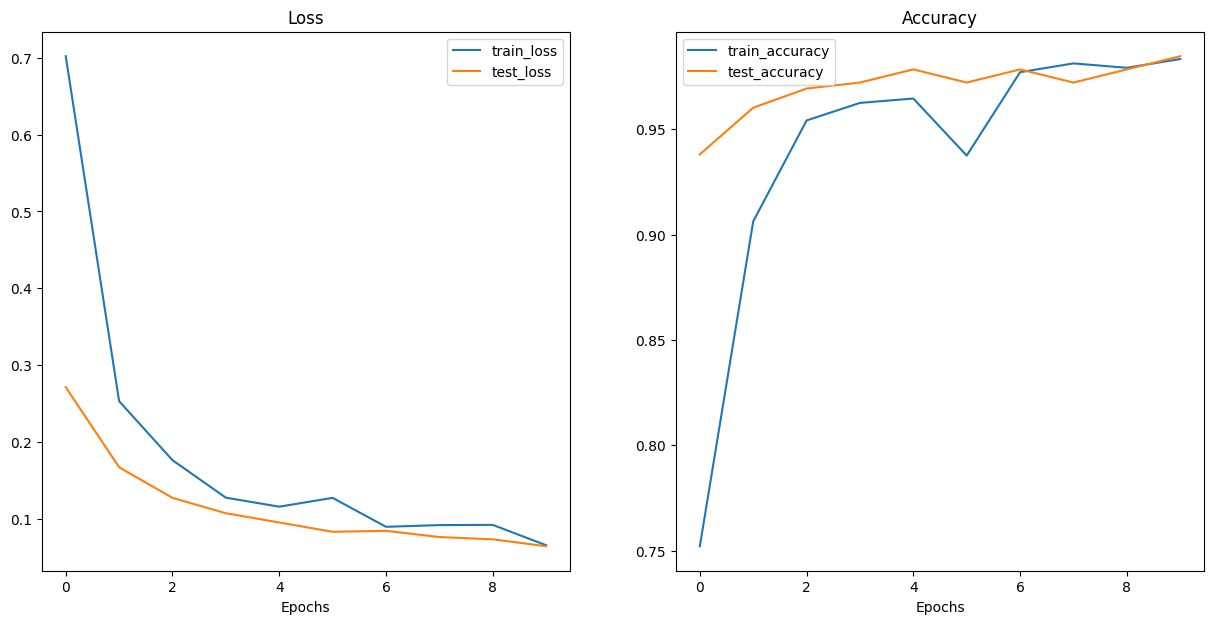

In [38]:
from helper_functions import plot_loss_curves
plot_loss_curves(vit_results)

In [42]:
# Save model
from going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


# 4.5 Checking the size of ViT feature extractor

In [44]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f"Size of pretrained ViT feature extractor model is {pretrained_vit_model_size} MB")

Size of pretrained ViT feature extractor model is 327 MB


In [45]:
pretrained_effnetb2_model_size

29

## 4.6 Collecting ViT feature extractor stats

In [46]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [47]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}
vit_stats

{'test_loss': 0.06444406402297317,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

In [48]:
effnetb2_stats

{'test_loss': 0.2804952323436737,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

# 5. Making predictions with our pretrained models and timing them

Our goal:
1. Performs well (95%+ test accuracy)
2. Fast (30+FPS)

To test criteria two:
1. Loop through test images
2. Time how long each model takes to make a prediction on the image

Let's work towards making a function called `pred_and_store()` to do so.

First we'll need a list of test image paths

In [50]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths

[WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/138961.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/148765.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1555015.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1618659.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/204151.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/2250611.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_pe

## 5.1 Creating a function to make across the test dataset

Steps to create `pred_and_store()`:

1. Create a function that takes a list of paths and a trained PyTorch and a series of transforms a list of target class names and a target device.
2. Create an empty list of target class names and a target device.
3. Loop through the atrget input paths (the rest of the steps will take place inside the loop).
4. Create an empty dictionary from each sample (prediction statistics will go in inside the here).
5. Get the sample path and ground truth class from the filepath.
6. Start the prediction timer.
7. Open the image using `PIL.Image(path)`.
8. Transform the image to be usable with a given model.
9. Prepare the model for inference by sending to the target device and turning on `eval()` mode.
10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
11. Add the pred prob + pred class to empty dictionary from step 4.
12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
13. See if the predicted class matches the ground truth class.
14. Append the updated prediction to the empty list of predictions we created in step 2.
15. Return the list of prediction dictionaries.

In [62]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function that takes a list of paths and a trained PyTorch and a series of transforms a list of target class names and a target device.
def pred_and_store(paths: List[pathlib.Path],
                   model:torch.nn.Module,
                   transform:torchvision.transforms,
                   class_names: List[str],
                   device: str = 'cuda' if torch.cuda.is_available() else 'cpu') -> List[Dict]:

    # 2. Create an empty list (can return a full list of all predictions later).
    pred_list = []

    # 3. Loop through the target input paths (the rest of the steps will take place inside the loop
    for path in tqdm(paths):

        # 4. Create an empty dictionary from each sample (prediction statistics will go in inside the here).
        pred_dict = {}
    
        # 5. Get the sample path and ground truth class from the filepath.
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_names"] = class_name
    
        # 6. Start the prediction timer.
        start_time = timer()
    
        # 7. Open the image using `Image.open(path)`.
        img = Image.open(path)
    
        # 8. Transform the image to be usable with a given model (also add a batch dimension and send to the target device
        transformed_image = transform(img).unsqueeze(0).to(device)
    
        # 9. Prepare the model for inference by sending to the target device and turning on `eval()` mode.
        model = model.to(device)
        model = model.eval()
    
        # 10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probability into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU (Python variables live on CPU)
    
            # 11. Add the pred prob + pred class to empty dictionary from step 4.
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
    
            # 12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)
    
            # 13. See if the predicted class matches the ground truth class.
            pred_dict["correct"] = class_name == pred_class
    
            # 14. Append the updated prediction to the empty list of predictions we created in step 2.
            pred_list.append(pred_dict)

    # 15. Return the list of prediction dictionaries.
    return pred_list

## 5.2 Making and timing predictions with EffNetB2

Let's test our `pred_and_store()` function.

Two things to note:
1. Device - we're going to hardcore our predictions to happen on CPU (because you won't always be sure of having a GPU when you deploy your model).
2. Transforms - we want to make sure each of the models are predicting on image that have been prepared with the appropriate transforms (e.g. EffNetB2 with `effnetb2_transforms`)

In [63]:
# Make predictions test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # hardcore predictions to happen on cpu

100%|██████████| 150/150 [00:09<00:00, 15.95it/s]


In [64]:
effnetb2_test_pred_dicts[:]

[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_names': 'pizza',
  'pred_prob': 0.9941,
  'pred_class': 'pizza',
  'time_for_pred': 0.0777,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_names': 'pizza',
  'pred_prob': 0.4663,
  'pred_class': 'pizza',
  'time_for_pred': 0.0525,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
  'class_names': 'pizza',
  'pred_prob': 0.992,
  'pred_class': 'pizza',
  'time_for_pred': 0.0543,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
  'class_names': 'pizza',
  'pred_prob': 0.7002,
  'pred_class': 'pizza',
  'time_for_pred': 0.0526,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg'),
  'class_names': 'pizza',
  'pred_prob': 0.7606,
  'pred_class': 'pizza',

In [68]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_names,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9941,pizza,0.0777,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.4663,pizza,0.0525,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9920,pizza,0.0543,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.7002,pizza,0.0526,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.7606,pizza,0.0535,True


In [66]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

correct
True     144
False      6
Name: count, dtype: int64

In [67]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred}")

EffNetB2 average time per prediction: 0.0621


In [80]:
# Add time per pred to EffNetB2 stats dictionary
effnetb2_stats["time_per_pred_cpu"] = float(effnetb2_average_time_per_pred)
effnetb2_stats

{'test_loss': 0.2804952323436737,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.0621}

**Note:** Prediction times will vary (much like training times) depending on the hardware you 're using... so generally the faster your compute (e.g. CPU or GPU), the faster the predictions will happen. 

## 5.3 Making and timing predictions with ViT

In [71]:
# Mkae list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu") # Hardcore device to CPU because not sure if GPU available when we deploy

100%|██████████| 150/150 [00:14<00:00, 10.01it/s]


In [72]:
# Check the first couple of ViT predictions
vit_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_names': 'pizza',
  'pred_prob': 0.9987,
  'pred_class': 'pizza',
  'time_for_pred': 0.3298,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_names': 'pizza',
  'pred_prob': 0.9957,
  'pred_class': 'pizza',
  'time_for_pred': 0.0978,
  'correct': True}]

In [74]:
# Turn vit_test_pred_dicts
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_names,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9987,pizza,0.3298,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9957,pizza,0.0978,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9987,pizza,0.0996,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9869,pizza,0.1090,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9698,pizza,0.1019,True


In [77]:
# See how many correct
vit_test_pred_df.correct.value_counts()

correct
True     148
False      2
Name: count, dtype: int64

In [78]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred}")

ViT average time per prediction: 0.0992


In [81]:
# Add average time per prediction to ViT stats
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06444406402297317,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': np.float64(0.0992)}

# 6. Comparing model results, prediction times and size

In [83]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Adde column for model names
df['model'] = ["EffNetB2", "ViT"]

# Convert accuracy to percentage
df['test_acc'] = round(df['test_acc'] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.280495,96.25,7705221,29,0.0621,EffNetB2
1,0.064444,98.47,85800963,327,0.0992,ViT


Which model is better?
* `test_loss` (lower is better) - ViT
* `test_acc` (higher is better) - ViT
*  `number_of_parameters` (generally lower is better_ - EffNetB2 (if a model has more parameters, it generally takes longer to compute)
   *  sometimes models with higher parameters can still perform fast.
* `model size(MB)` - EffNetB2 (for our use case of deploing to a mobile device, generally lower is better)
* `time_per_pred_cpu` (lower is better, will be highly dependent on the hardware you're running on) - EffNetB2 (btw, there's only a slight difference in time here).

Both models fail to achieve our goal of 30+FPS... however we could always just try and use EffNetB2 and see how it goes.

In [86]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index('model').loc['ViT'] / df.set_index('model').loc['EffNetB2']),
             columns=['ViT to EffNetB2 ratios']).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.229751,1.023065,11.135432,11.275862,1.597424


## 6.1 Visualizing the speed vs performance tradeoff

So we've compared our EffNetB2 and ViT feature extractor models, now let's visualize the comparison with a speed vs performance plot.

We can do so with matplotlib:
1. Create a scatter plots from the comparison DataFrame to compare EffNetB2 and ViT across test accuracy and prediction time.
2. Add titles and labels to make our plot look nice.
3. Annotate the samples on the scatter plot so we know what's going on.
4. Create a legend based on the model sizes (`model_size (MB)`)

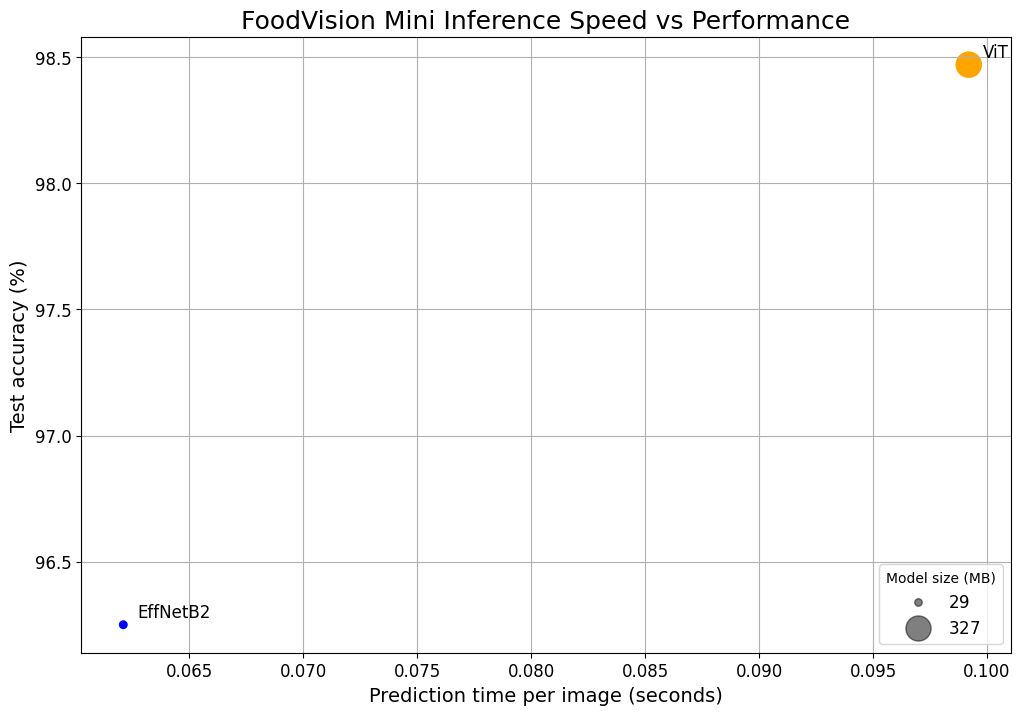

In [98]:
# 1. Create a plot from model comparison DataFrame
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)")

# 2. Add titles and labels to make our plot look good
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

# 3. Annotate the samples on the scatter plot so we know what's going on.
for index, row in df.iterrows():
    ax.annotate(text=row['model'],
                xy=(row["time_per_pred_cpu"]+ 0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on the model sizes (`model_size (MB)`)
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)
# Save the figure
plt.savefig("09-foodvision-mini-inference-speed-vs-performance.png")

In [101]:
pip install gradio

  Using cached gradio-5.35.0-py3-none-any.whl.metadata (16 kB)
  Using cached aiofiles-24.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached ffmpy-0.6.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached gradio_client-1.10.4-py3-none-any.whl.metadata (7.1 kB)
  Using cached groovy-0.1.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached huggingface_hub-0.33.1-py3-none-any.whl.metadata (14 kB)
  Using cached orjson-3.10.18-cp312-cp312-win_amd64.whl.metadata (43 kB)
  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached python_multipart-0.0.20-py3-none-any.whl.metadata (1.8 kB)
  Using cached ruff-0.12.1-py3-none-win_amd64.whl.metadata (26 kB)
  Using cached safehttpx-0.1.6-py3-none-any.whl.metadata (4.2 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached tomlkit-0.13.3-py3-none-any.whl.metadata (2.8 kB)
  Using cached typer-0.16.0-py3-none-any.whl.metadata (15 kB)
  Using cached uvicorn-0.35.0-py3-none-any.whl.metad


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Deepam Shah\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


# 7. Bringing FoodVision Mini to life by creating a Gradio demo

We've chosen to deploy EffNetB2 as it fulfils our criteria the best.

What is Gradio?
> Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere! (https://www.gradio.app/)

In [102]:
import gradio as gr
print(f"Gradio version: {gr.__version__}")

Gradio version: 5.35.0


## 7.1 Gradio overview

Gradio helps you create machine learning demos.

Why create a demo?

So other people can try our models and we can test them in the real-world.

Deployment is as important as training.

The overall premise of Gradio is to map inputs -> function/model -> outputs.

## 7.2 Creating a function to map our inputs and outputs

In [103]:
# Put our model on the CPU
effnetb2 = effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

Let's create a function `predict()` to go from:

```
images of food -> ML model (EffNetB2) -> outputs (food class label, prediction time)
```

In [106]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    # Start a timer
    start_time = timer()
    
    # Transform the input image for use with EffNetB2
    img = effnetb2_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index
    
    # Put the model into eval mode, make prediction
    effnetb2.eval()
    with torch.inference_mode():
        # Pass transformerd image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
        
    # Create a prediction label and pediction probability dictionary
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate pred time
    end_time = timer()
    pred_time = round(end_time - start_time, 4) 
    
    # Return pred dict and pred time
    return pred_labels_and_probs, pred_time

[INFO] Predicting on image at path: data\pizza_steak_sushi_20_percent\test\steak\595836.jpg

{'pizza': 0.12870469689369202, 'steak': 0.7844998240470886, 'sushi': 0.08679552376270294}
0.202


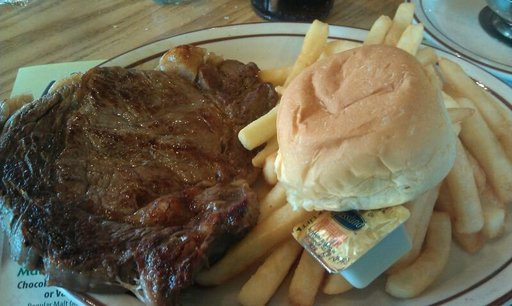

In [117]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[0]

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0] # .sample() method returns a new list, hence we did [0]
random_image_path

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)
image

## 7.3 Creating a list of example images

The examples for Gradio can be created with the `examples` parameter

In [118]:
# Create list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data\\pizza_steak_sushi_20_percent\\test\\sushi\\389730.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\steak\\1882831.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\steak\\100274.jpg']]

## 7.4 Building a Gradio Interface

Let's use `gr.interface()` to go from:

```
input: image -> transform -> predict with EffNetB2 -> output: pred_prob, pred_time
```

In [119]:
import gradio as gr

# Create title, description and article
title = "FoodVision Mini 🍕🥩🍣"
description = "An [EfficientNetB2 feature extractor](https://docs.pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) computer vision model to classify images as pizza, steak or sushi."
article = "Created at 09. [PyTorch Model Deloyment](https://www.learnpytorch.io/09_pytorch_model_deployment/)"

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # Print errors locally?
            share=True) # Generate a publically shareable URL

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://410ebb3ab94f270111.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Created dataset file at: .gradio\flagged\dataset1.csv


Traceback (most recent call last):
  File "C:\Users\Deepam Shah\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\queueing.py", line 626, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Deepam Shah\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Deepam Shah\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\blocks.py", line 2220, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Deepam Shah\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\blocks.py", line 1731, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Use

# 8. Turning our FoodVision Mini Gradio Demo into a deployable app

Our Gradio demos from Jupyter Notebook are fantastic but they expire within a week.

To fix this, we're going to prepare our app files so we can host them on HuggingFace Spaces: (https://huggingface.co/docs/hub/spaces#spaces)

## 8.1 What is Hugging Face Spaces?

> Hugging Face Spaces offer a simple way to host ML demo apps directly on your profile or your organization’s profile. This allows you to create your ML portfolio, showcase your projects at conferences or to stakeholders, and work collaboratively with other people in the ML ecosystem.

If GitHub is a place to show your coding ability, Hugging Face Spaces is a place to show your machine learning ability (through sharing ML demos that you've built).

## 8.2 Deployed Gradio app structure

Let's start to put all of our app files into a single directory:

```
Jupyter Notebook -> folder with all Gradio files -> upload app files to Higging Face Spaces -> deploy
```

By the end our file structure will look like this:

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

## 8.3 Creating a `demos` folder to store our FoodVision app files

In [121]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might exist and create a new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents=True,
                                    exist_ok=True)

else:
    foodvision_mini_demo_path.mkdir(parents=True,
                                    exist_ok=True)


## 8.4 Creating a folder of example images to use with our FoodVision Mini demo

What we want:
* 3 images in an `examples`/ directory
* Images should be from the test set

In [123]:
import shutil
from pathlib import Path

# Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# Copy the three images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example,
                 dst=destination)
    

[INFO] Copying data\pizza_steak_sushi_20_percent\test\sushi\592799.jpg to demos\foodvision_mini\examples\592799.jpg
[INFO] Copying data\pizza_steak_sushi_20_percent\test\steak\3622237.jpg to demos\foodvision_mini\examples\3622237.jpg
[INFO] Copying data\pizza_steak_sushi_20_percent\test\pizza\2582289.jpg to demos\foodvision_mini\examples\2582289.jpg


Let's now verify that we can get a list of lists from our `examples`/ directory

In [124]:
import os

# Get example filepaths in a list of lists
example_list = [["example/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['example/2582289.jpg'], ['example/3622237.jpg'], ['example/592799.jpg']]

## 8.5 Moving our trained EffNetB2 model to our FoodVision Mini demo directory

In [172]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_Pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the model file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path,
                dst=effnetb2_foodvision_mini_model_destination)
    print(f"[INFO] model move complete")
# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}:{effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_Pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos\foodvision_mini\09_Pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] No model found at models/09_Pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth, perhaps its already been moved?
[INFO] Model exists at demos\foodvision_mini\09_Pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth:True


# 8.6 Turning off EffNetB2 model into a Python script (`model.py`)

We have a saved `.pth` model `state_dict` and want to load it into a model instance.

Let's move our `create_effnetb2_model()` function to a script so we can reuse it.

In [188]:
%%writefile demos/foodvision_mini/model1.py

import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes: int = 3,  # default output classes = 3 (pizza, steak, sushi)
                          seed: int = 42):
    # 1, 2, 3 Create EffNetB2 pretrained weights, transforms, and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    effnet = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in the base model
    for param in effnet.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    effnet.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )

    return effnet, transforms

Overwriting demos/foodvision_mini/model1.py


In [177]:
from demos.foodvision_mini import model1

In [178]:
from demos.foodvision_mini.model1 import create_effnetb2_model

## 8.7 Turning our FoodVision Mini Gradio app into a Python script ('app.py')

The `app.py` file will have four major parts:
1. Imports and class names setup
2. Model and transforms preparation
3. Predict function (`predict()`)
4. Gradio app - our Gradio interface + launch command

In [183]:
%%writefile demos/foodvision_mini/app.py

### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from demos.foodvision_mini.model1 import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['pizza', 'steak', 'sushi']

### 2. Model and transforms preparation ###
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3)

# Load save weights
effnetb2.load_state_dict(
    torch.load(
        f="09_Pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu") # load the model to the CPU
    )
)

### 3. Predict function ###
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    # Start a timer
    start_time = timer()
    
    # Transform the input image for use with EffNetB2
    img = effnetb2_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index
    
    # Put the model into eval mode, make prediction
    effnetb2.eval()
    with torch.inference_mode():
        # Pass transformerd image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
        
    # Create a prediction label and pediction probability dictionary
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate pred time
    end_time = timer()
    pred_time = round(end_time - start_time, 4) 
    
    # Return pred dict and pred time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

import gradio as gr

# Create title, description and article
title = "FoodVision Mini 🍕🥩🍣"
description = "An [EfficientNetB2 feature extractor](https://docs.pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) computer vision model to classify images as pizza, steak or sushi."
article = "Created at 09. [PyTorch Model Deloyment](https://www.learnpytorch.io/09_pytorch_model_deployment/)"

# Create example list
example_list = [["example/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False) # Print errors locally?
          

Overwriting demos/foodvision_mini/app.py


## 8.8 Creating `requirements.txt`

The requirements file will tell our Hugging Face Space what software dependencies our app requires.

The three main ones are:
* torch
* torchvision
* gradio

In [184]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4
numpy<2

Overwriting demos/foodvision_mini/requirements.txt


# 9. Deploying our FoodVision Mini app to HuggingFace Spaces
We've got a file containing our FoodVision Mini demo, now how do we get it to run on Hugging Face Spaces?

There are two main options for uploading to a Hugging Face Space (also called a Hugging Face Repository, similar to a git repository):

* Uploading via the Hugging Face Web interface (easiest).
* Uploading via the command line or terminal.
  * Bonus: You can also use the huggingface_hub library to interact with Hugging Face, this would be a good extension to the above two options.

## 9.1 Downloading our FoodVision Mini app files

We want to download our `foodvision_mini` demo app so we can upload it to Hugging Face Spaces.

In [185]:
# Change into the foodvision_mini directory and then zip it from the inside
# !cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

import os
import zipfile

def zipdir(path, ziph, exclude_ext=None):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            if exclude_ext and any(file.endswith(ext) for ext in exclude_ext):
                continue
            filepath = os.path.join(root, file)
            arcname = os.path.relpath(filepath, os.path.dirname(path))
            ziph.write(filepath, arcname)

# Usage
with zipfile.ZipFile('foodvision_mini.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipdir('demos/foodvision_mini', zipf, exclude_ext=['.pyc', '.ipynb'])


In [186]:
from IPython.display import display, HTML

zip_path = "demos/foodvision_mini.zip"

try:
    if not os.path.isfile(zip_path):
        raise FileNotFoundError("Zip file not found.")

    display(HTML(f'<a download href="{zip_path}">Download foodvision_mini.zip</a>'))

except Exception as e:
    print(f"An error occurred: {e}")

# 10. Creating FoodVision Big!!!

FoodVision Mini works well with 3 classes (pizza, steak, sushi)

So all of experimenting is paying off...

Let's step up a notch and make FoodVision BIG!!! using all of the Food101 classes.

## 10.1 Creating a model for FoodVision Big + transforms

In [190]:
import torch
import torchvision
from torch import nn

def create_effnetb2_model_food101(num_classes: int = 3,  # default output classes = 3 (pizza, steak, sushi)
                          seed: int = 42):
    # 1, 2, 3 Create EffNetB2 pretrained weights, transforms, and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    effnet = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in the base model
    for param in effnet.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    effnet.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )

    return effnet, transforms

In [191]:
# Create Food101 model and transforms
effnetb2_food101, effnetb2_transforms = create_effnetb2_model_food101(num_classes=101)

In [192]:
from torchinfo import summary

summary(model=effnetb2_food101,
        input_size=(1, 3, 224, 224), 
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=["var_names"]) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Since we're working with a larget dataset, we may want to introduce some data augmentation techniques:
* This is because with larger datasets and larger models, overfitting becomes more of a problem.
* Because we're worknig with a large number of classes, let's use TrivialAugment as our data augmentation technique.

For a list of state-of-the-art computer vision recipes: (https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/)

In [193]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [197]:
# Create training data transforms
food_101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms])

food_101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [198]:
# Testing data transform
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

## 10.2 Getting data for FoodVision Big

Get Food101 dataset:- (https://docs.pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html)

In [199]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get the training data (~750 image x 101 classes)
train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform=food_101_train_transforms, # apply data augmentation to training data
                              download=True)

test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms, # don't perform data augmentation on the test data
                             download=True)

100%|██████████| 5.00G/5.00G [31:33<00:00, 2.64MB/s]   


Extracting data\food-101.tar.gz to data


In [203]:
750*101, 250*101

(75750, 25250)

In [204]:
# Get Food101 classnames
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

# 10.3 Creating a subset of the Food101 dataset for faster experimenting

Why create a subset?

We want our first few experiments to run as quick as possible.

We know FoodVision Mini works pretty well but this is the first time we've upgraded to 101 classes.

To do so, let's make a subset of 20% of the data from the Food101 dataset (training and test)

Our short-term goal: to beat the original Food101 paper result of 56.4% accuracy on the test dataset 

We want to beat this result using modern deep learning techniques and only 20% of the data.

In [205]:
len(train_data), len(test_data)

(75750, 25250)

In [206]:
len(train_data)*0.2, len(test_data)*0.2

(15150.0, 5050.0)

In [208]:
from torch.utils.data import random_split # Read more about random_split

def split_dataset(dataset:torchvision.datasets,
                  split_size:float=0.2,
                  seed:int=42):
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size) # defaults to 20% split
    length_2 = len(dataset) - length_1 # remaining length

    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} and {length_2}")

    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed))

    return random_split_1, random_split_2

In [209]:
# Create training 20% split Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 and 60600
[INFO] Splitting dataset of length 25250 into splits of size: 5050 and 20200


In [210]:
len(train_data_food101_20_percent), len(test_data_food101_20_percent)

(15150, 5050)

## 10.4 Turning our Food101 datasets into `Dataloaders`

In [211]:
import os

os.cpu_count()

28

In [213]:
import os
import torch

NUM_WORKERS = 2 
BATCH_SIZE = 32

# Create Food101 20% training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)

test_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)


In [214]:
len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(474, 158)

## 10.5 Training FoodVision Big!!!

Things for training!
* 5 epochs
* Optimizer: `torch.optim.Adam(lr=1e-3)
* Loss function: `torch.nn.CrossEntropyLoss(label_smoothing=0.1)`

Why use label smoothing?

Label smoothing helps to prevent overfittng (it's a regularization technique).

Without label smoothing and 5 classes:

```
[0.00, 0.00, 0.99, 0.01, 0.01]
```

With label smoothing and 5 classes:

```
[0.01, 0.01, 0.96, 0.01, 0.01]
```

In [215]:
from going_modular import engine

# Setup Optimizer 
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Setup loss
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Want to beat the original Food101 paper's result of 56.4% accuracy on the test dataset with 20% of the data.
set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

 20%|██        | 1/5 [04:24<17:38, 264.55s/it]

Epoch: 1 | train_loss: 3.6398 | train_acc: 0.2795 | test_loss: 2.7818 | test_acc: 0.4923


 40%|████      | 2/5 [06:53<09:49, 196.50s/it]

Epoch: 2 | train_loss: 2.8591 | train_acc: 0.4406 | test_loss: 2.4728 | test_acc: 0.5346


 60%|██████    | 3/5 [09:19<05:46, 173.41s/it]

Epoch: 3 | train_loss: 2.6528 | train_acc: 0.4866 | test_loss: 2.3650 | test_acc: 0.5582


 80%|████████  | 4/5 [11:46<02:42, 162.86s/it]

Epoch: 4 | train_loss: 2.5500 | train_acc: 0.5114 | test_loss: 2.3010 | test_acc: 0.5741


100%|██████████| 5/5 [14:03<00:00, 168.76s/it]

Epoch: 5 | train_loss: 2.4899 | train_acc: 0.5266 | test_loss: 2.2784 | test_acc: 0.5790


We've just done something in ~18 minutes that wasn't possible 10 years ago(with only 20% of total data).

## 10.6 Inspecting loss curves of FoodVision Big model

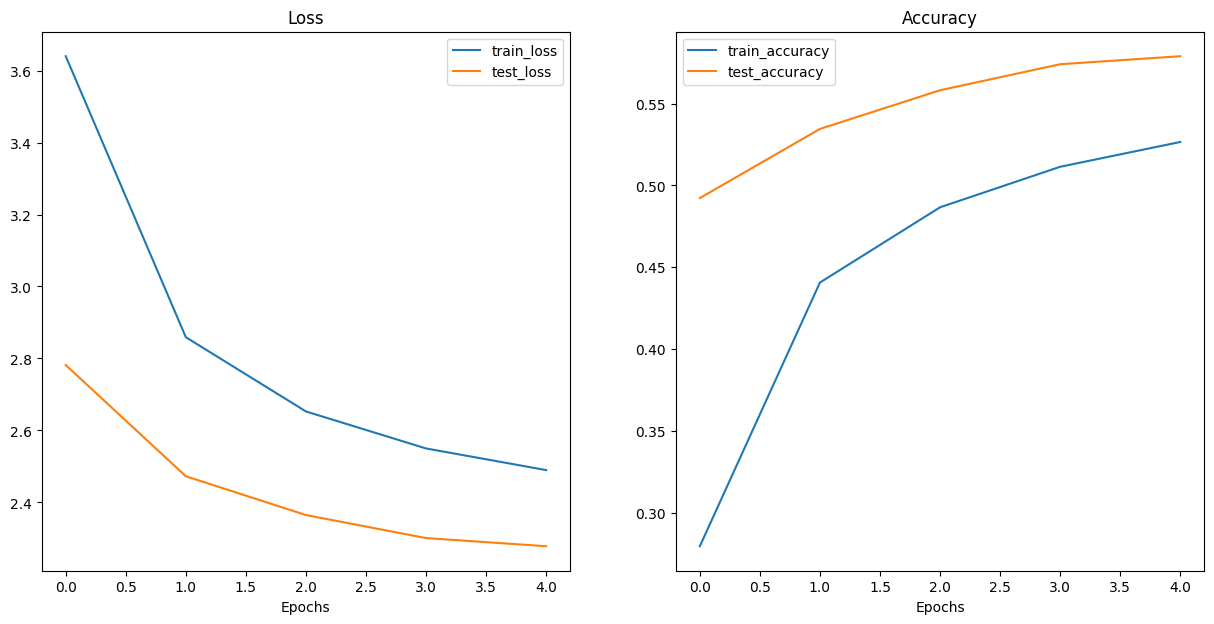

In [216]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_food101_results)

## 10.7 Save and Load FoodVision Big model

* Saving = storing what the model has learned (weights).

* Loading = re-creating the model and injecting those weights to use it again.

### Use Cases:

* Inference on new data

* Resuming interrupted training (checkpointing)

* Deployment in production apps

* Transfer learning on a different dataset



In [218]:
from going_modular import utils

# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models/",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models\09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [222]:
# Create Food101 compatible Effnetb2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model_food101(num_classes=101)

# Load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

C:\Users\Deepam Shah\AppData\Local\Temp\ipykernel_9256\1317947527.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_effnetb2_food101.load_state_dict(torch.load("mod

<All keys matched successfully>

## 10.8 Checking FoodVision Big model size

In [224]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 29 MB


# 11. Turning our FoodVision Big model into a deployable app

Why deploy a model?

Deploying a model allows you to see how your model goes in the real-world(the ultimate test set)

Let's create an outline for our FoodVision Big app:
```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```

In [2]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make foodvision Big demo directory
foodvision_big_demo_path.mkdir(parents=True,
                               exist_ok=True)

# Make foodvision big demo example directory
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

## 11.1 Downloading an example image and moving it to the `examples` directory

In [3]:
# i directly downloaded the sample image
# Also manually moved the food101 ".pth" file from models to foodvisin_big

## 11.2 Saving Food101 class names to file(`class_names.txt`)

Let's save all of the Food101 class names to a .txt file so we can import them and use in our app.

In [4]:
# Check out the first 10 Food101 class names
food101_class_names[:10]

NameError: name 'food101_class_names' is not defined

In [5]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"
foodvision_big_class_names_path

WindowsPath('demos/foodvision_big/class_names.txt')

In [230]:
# Write Food101 class names to text file
with open(foodvision_big_class_names_path, 'w') as f:
    print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
    f.write("\n".join(food101_class_names)) # new line per class name

[INFO] Saving Food101 class names to demos\foodvision_big\class_names.txt


In [1]:
# Open Food101 class name file and read each line into a list
with open(foodvision_big_class_names_path, 'r') as f:
    food101_class_names_loaded = [food.strip() for food in f.readlines()] # run it again after removing.strip() method

food101_class_names_loaded

NameError: name 'foodvision_big_class_names_path' is not defined

## 11.3 Turning our FoodVision Big model into a Python script(`model.py`)

In [234]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn

def create_effnetv2_model(num_classes:int=3, # default output classes = 3 (pizza, steak, sushi
                          seed:int=42):
    # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4 Freeze all layers in the base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )

    return model, transforms

Writing demos/foodvision_big/model.py


## 11.4 Turning our FoodVision Big Gradio app into a Python script(`app.py`)

The `app.py` file will have four major parts:
1. Imports and class names setup - for class names, we'll need to import from `class.names.txt` rather than with a Python list
2. Model and transforms preparation - we'll need to make sure our model is suitable for FoodVision Big
3. Predict function (`predict()`) - this can stay the same as the original `predict()`
4. Gradio app - our Gradio interface + launch command - this will change slightly from FoodVision Mini to reflect the FoodVision Big updates

In [235]:
%%writefile demos/foodvision_big/app.py

### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", 'r') as f:
    class_names = [food_name.strip() for food_name in f.readlines()]

### 2. Model and transforms preparation ###
# Create model and transforms
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
              map_location=torch.device("cpu")) # load to cpu
)

### 3. predict function ###
def predict(img) -> Tuple[Dict, float]:
    # Start a timer
    start_time = timer()
    
    # Transform the input image for use with EffNetB2
    img = effnetb2_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index
    
    # Put the model into eval mode, make prediction
    effnetb2.eval()
    with torch.inference_mode():
        # Pass transformerd image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
        
    # Create a prediction label and pediction probability dictionary
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate pred time
    end_time = timer()
    pred_time = round(end_time - start_time, 4) 
    
    # Return pred dict and pred time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

import gradio as gr

# Create title, description and article
title = "FoodVision Big 🍔👁️💪"
description = "An [EfficientNetB2 feature extractor](https://docs.pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) computer vision model to classify images 101 classes of food from the Food101 dataset."
article = "Created at 09. [PyTorch Model Deloyment](https://www.learnpytorch.io/09_pytorch_model_deployment/#11-turning-our-foodvision-big-model-into-a-deployable-app)"

# Create example list
example_list = [["example/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=5, label="predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()        

Writing demos/foodvision_big/app.py


## 11.5 Creating a requirements file for FoodVision Big (`requirements.txt`)

In [236]:
%%writefile demos/foodvision_big/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4
numpy<2

Writing demos/foodvision_big/requirements.txt


## 11.6 Downloading our FoodVision Big app files

In [239]:
import os
import zipfile

def zipdir(path, ziph, exclude_ext=None):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            if exclude_ext and any(file.endswith(ext) for ext in exclude_ext):
                continue
            filepath = os.path.join(root, file)
            arcname = os.path.relpath(filepath, os.path.dirname(path))
            ziph.write(filepath, arcname)

# Usage
with zipfile.ZipFile('foodvision_big.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipdir('demos/foodvision_big', zipf, exclude_ext=['.pyc', '.ipynb'])

In [240]:
from IPython.display import display, HTML

zip_path = "demos/foodvision_big.zip"

try:
    if not os.path.isfile(zip_path):
        raise FileNotFoundError("Zip file not found.")

    display(HTML(f'<a download href="{zip_path}">Download foodvision_big.zip</a>'))

except Exception as e:
    print(f"An error occurred: {e}")

## 11.7 Deploying our FoodVision Big model app to Hugging Faces Spaces

Let's bring FoodVision Big to life by deploying it to the world!!!

See steps here: (https://www.learnpytorch.io/09_pytorch_model_deployment/#117-deploying-our-foodvision-big-app-to-huggingface-spaces)

See our deployed app here:- (https://huggingface.co/spaces/DeepXAi/foodvision_big)